# Single-shot image-based autofocus with machine learning

This shows how to reproduce the data collection aspects of the paper:

[Henry Pinkard, Zachary Phillips, Arman Babakhani, Daniel A. Fletcher, and Laura Waller, "Deep learning for single-shot autofocus microscopy," Optica 6, 794-797 (2019)](https://doi.org/10.1364/OPTICA.6.000794)

In this paper, we show how the existing transmitted light path and camera on a microscope can be used collect a single image, which can then be fed into a neural network to predict how far out of focus that image is so the Z-stage can be moved back into the correct focal plane.

In particular, this tutorial will show: 1) How to create the neccessary hardware for the system. 2) How to use Micro-Magellan to easily collect training data 3) How to use [Pycro-Manager](https://pycro-manager.readthedocs.io/en/latest/) to apply a trained network to apply focus corrections during subsequent experiments. An [different notebook](https://figshare.com/articles/Single-shot_autofocus_microscopy_using_deep_learning--code/7453436/1) shows the steps in between (2) and (3) of processing data and training the network.

This tutorial assumes the use of a Micro-Manager configuration with motorized XY and Z stages.


## Background

Many biological experiments involve imaging samples in a microscope over long time periods or large spatial scales, making it difficult to keep the sample in focus. When observing a sample over time periods of hours or days, for example, thermal fluctuations can induce focus drift. Or, when scanning and stitching together many fields-of-view (FoV) to form a high-content, high-resolution image, a sample that is not sufficiently flat necessitates refocusing at each position. Since it is often experimentally impractical or cumbersome to manually maintain focus, an automatic focusing mechanism is essential. 

Many hardware and software-based solutions have been proposed for this problem. Hardware solutions are, in general, more expensive and faster, while software methods tend to be slower. The technique we propose here aims to capture the benefits of each: A fast method for autofocusing that requires minimal, cheap hardware. The most basic software autofocus method is to simply take a focal stack of images, calculate some metric of image sharpness over the stack, and find the peak.

In our technique, we will bootstrap training data best on this basic method for generating ground truth. That is, we will collect paired Z-stacks of a sample, one with incoherent illumination (i.e. regular transmitted light with the aperture not fully closed down), and the other with coherent illumination, as provided by an off-axis LED illuminating the sample. A single plane of the latter will be used as the input to a neural network that can predict the correct focal position.

## Overview

This tutorial will go through the full process in the figure below and is broken down in the following sections

1) Hardware setup

 -  How to choose off-axis illumination
 
 -  How to control through Micro-Manager

2) Collect training data (part a in figure below)

3) Use trained network to apply focus corrections during experiments (part b in figure below)

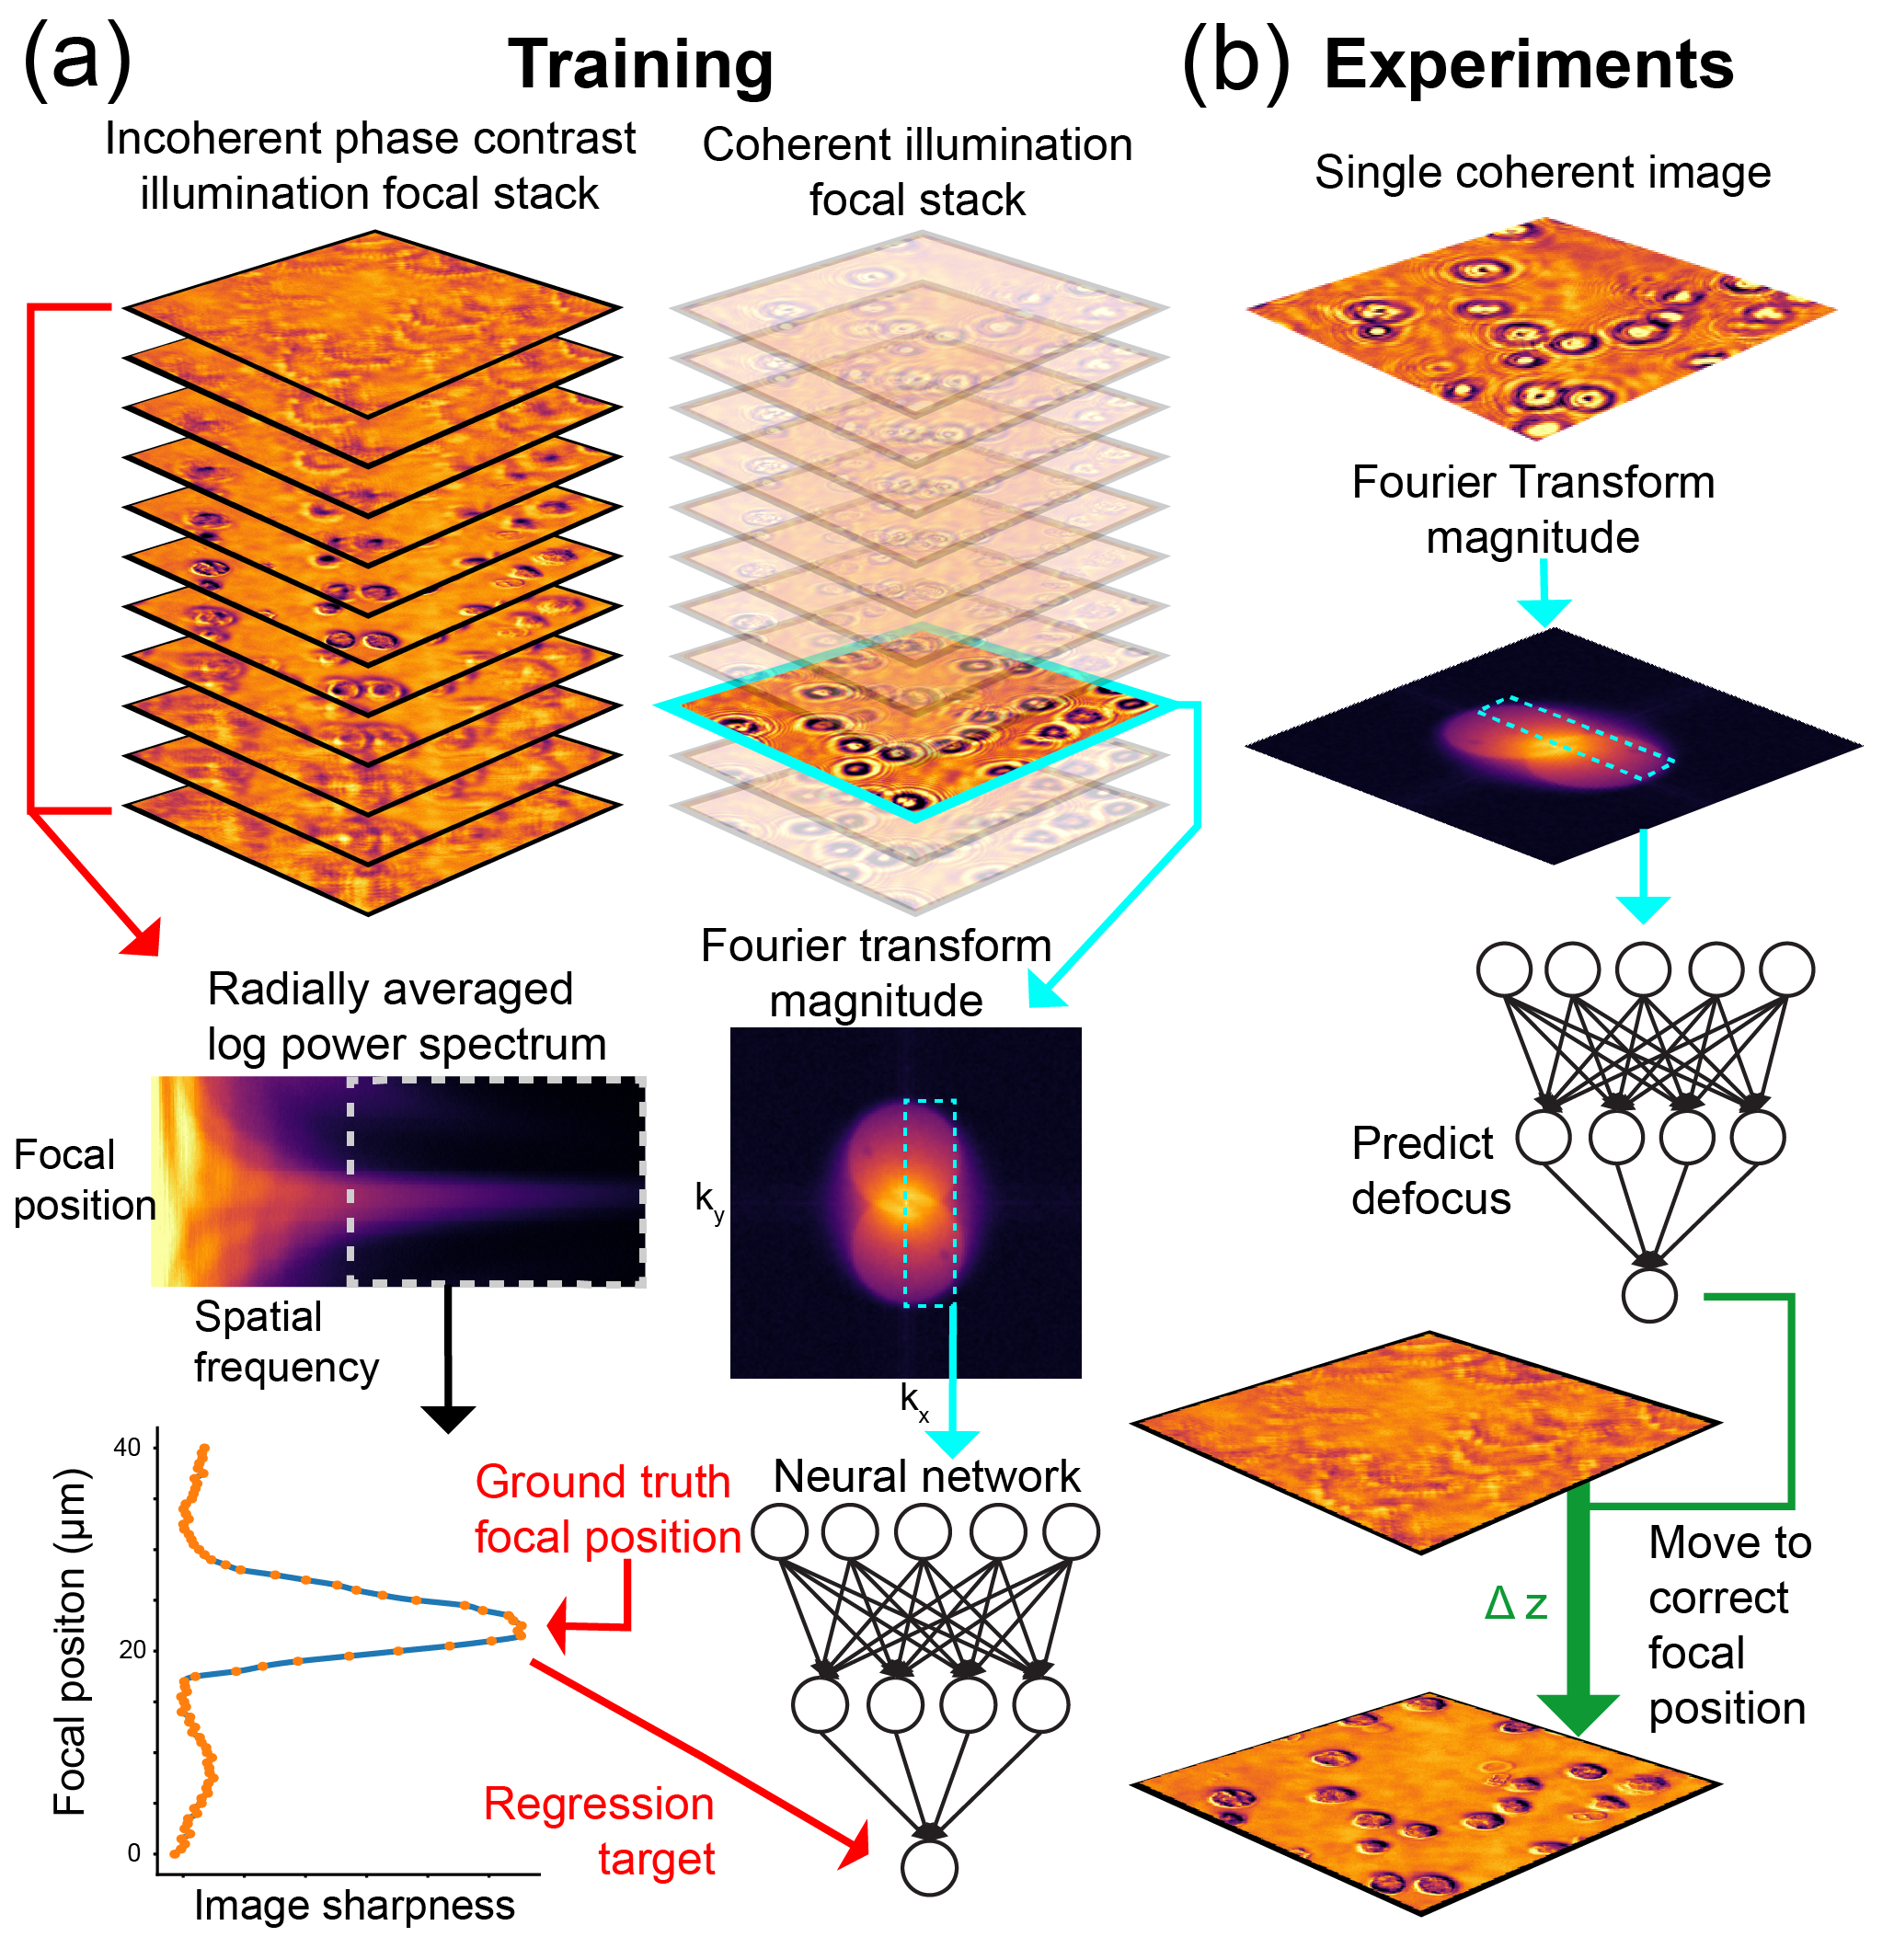

## 1) Hardware setup

This technique requires some type of off-axis, coherent illumination. We can easily achieve this by placing one or a few LED(s) off axis to illuminate the sample.

### How to choose off-axis illumination

As we show in the paper, different LED positions and different patterns of LEDs can be more or less effective for this task (see figure below). The best performing networks used ~10 LEDs, all in a straight line on one side of the optical axis.

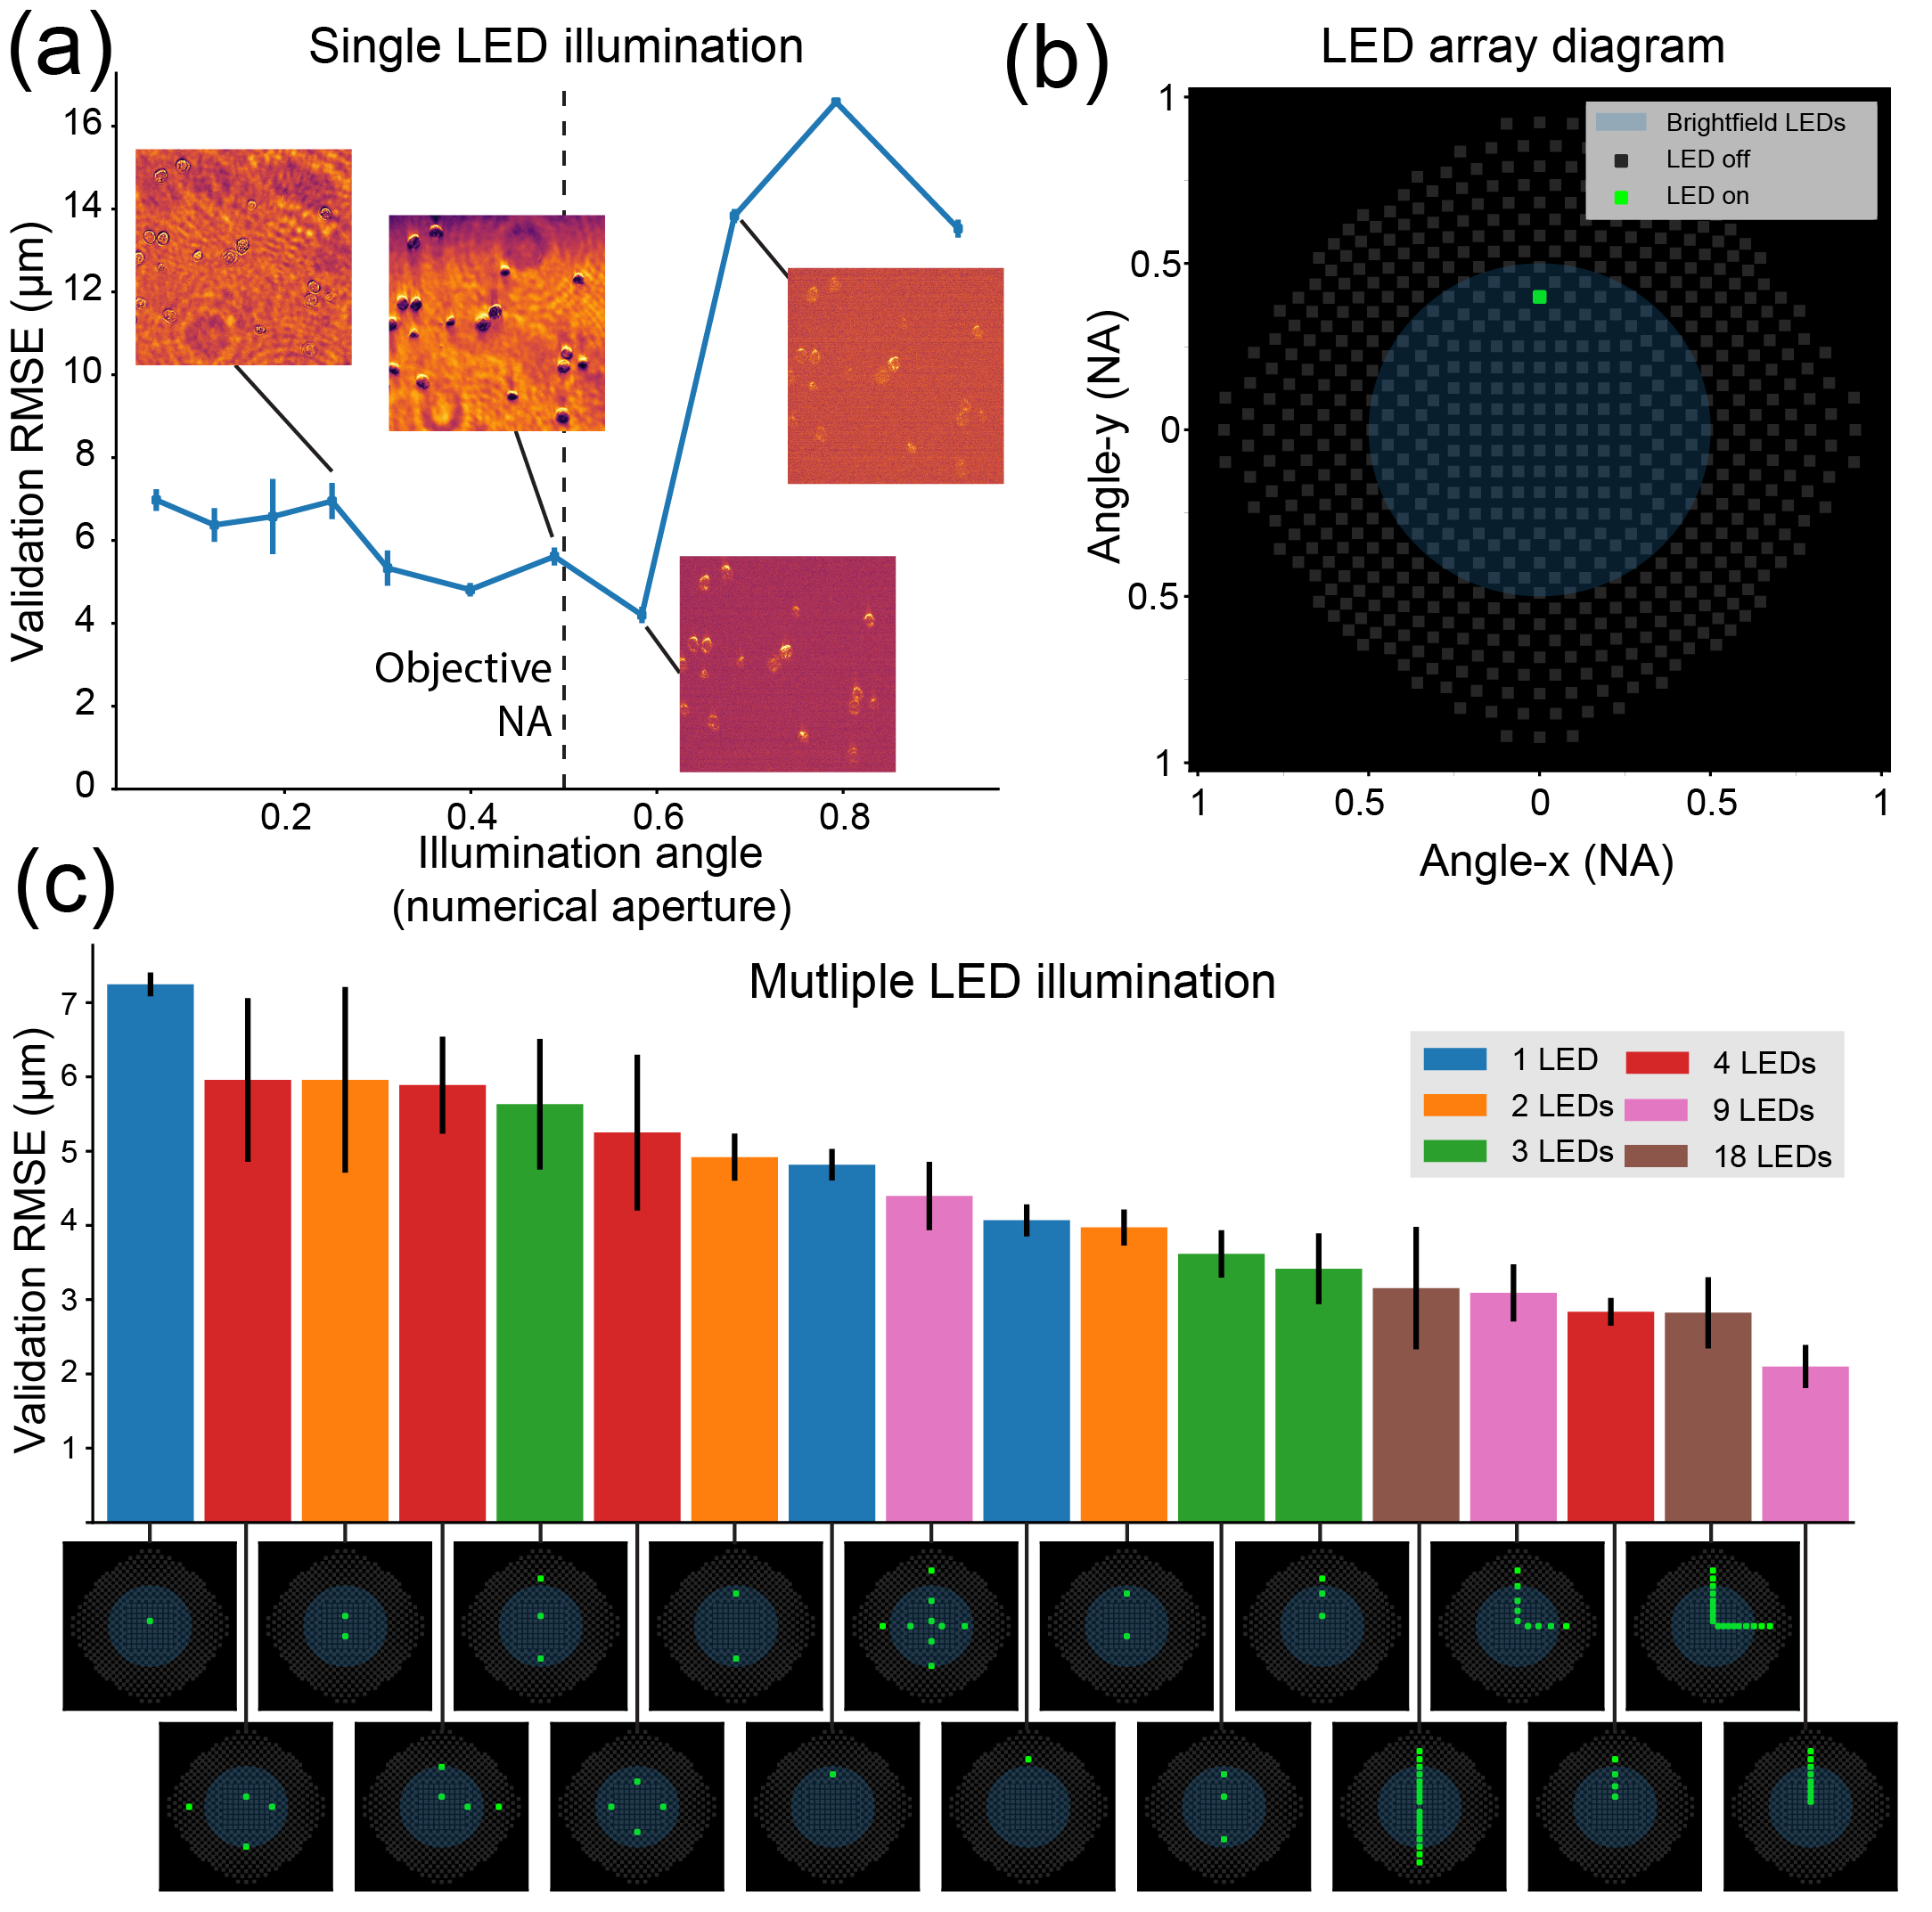

### How to control through Micro-Manager

The easiest way to set up this type of illumination in Micro-Manager is with the [Arduino device adapter](https://micro-manager.org/wiki/Arduino#PWM). Essentially, you can wire up a simple circuit, load the provided firmwire onto the arduino, and then use the device API in Micro-Manager to control this circuit.

## 2) Collect training data

Now we're going to collect 2-channel Z-stacks, where one channel is the coherent illumination we just set up, and the other channel is uses incoherent illumination (which gets more blurry when out of focus, and making it easier to calculate the ground truth focal position)

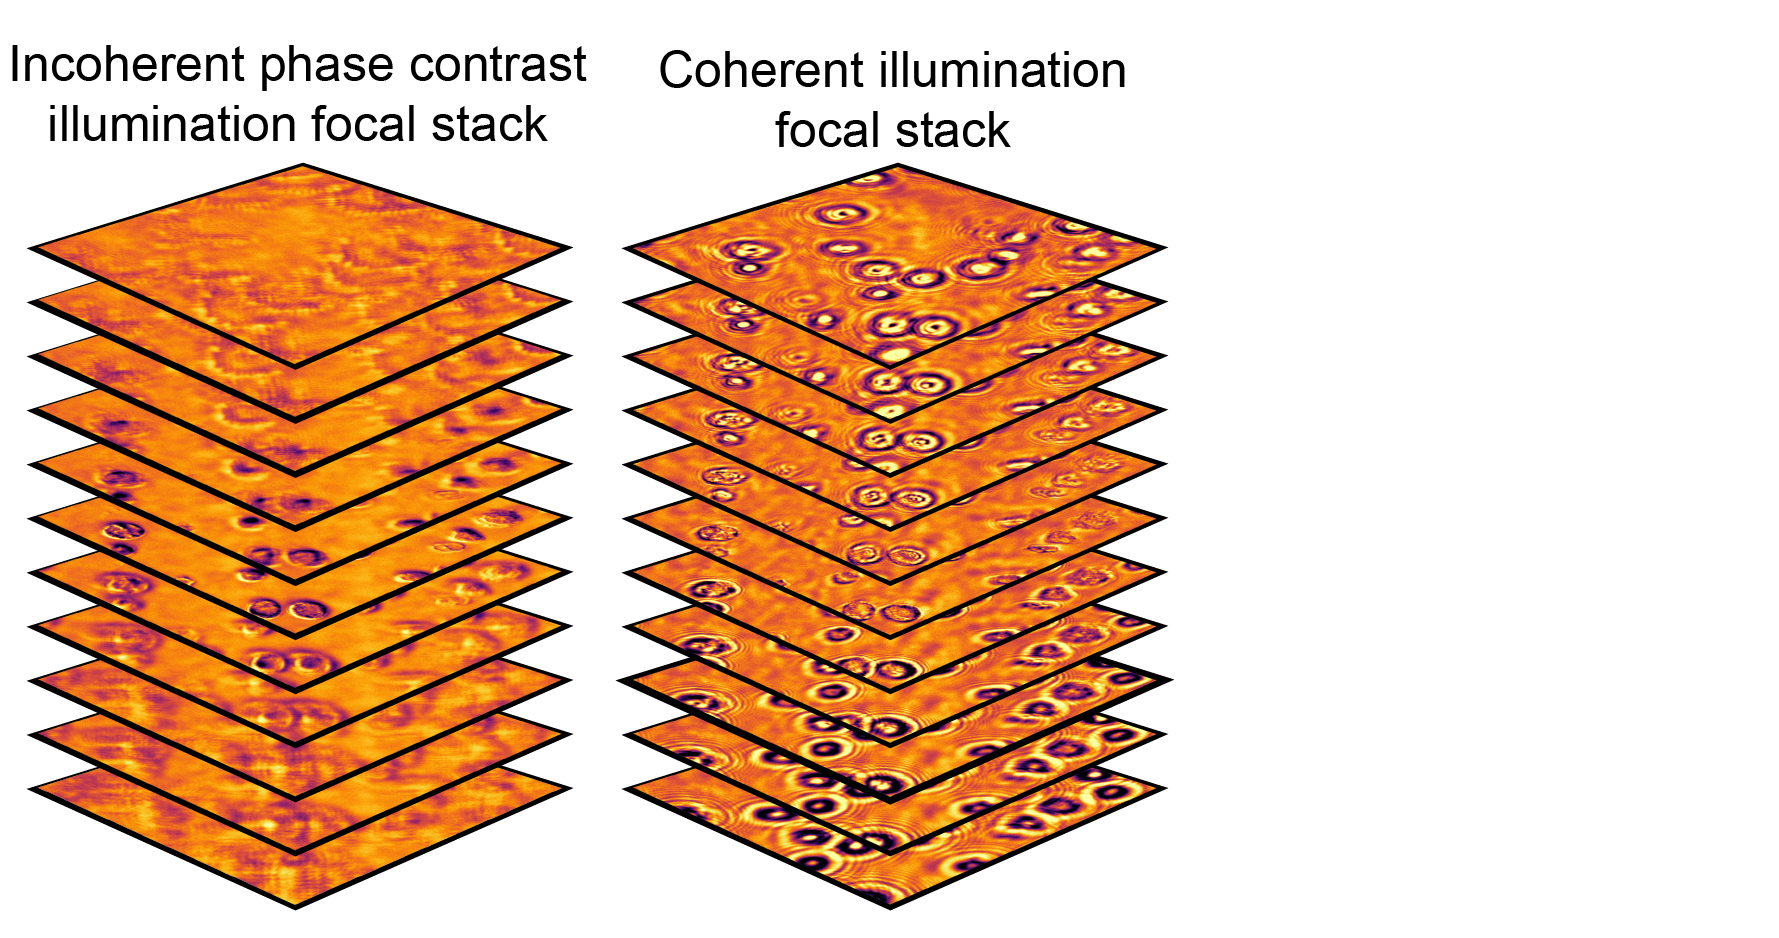

### Calibrating XY stage for Micro-Magellan
[Micro-Magellan](https://micro-manager.org/wiki/MicroMagellan) provides a convenient graphical user interface for collecting a many of such Z stacks. In order to use its features, we need to calibrate the "affine transform" matrix, which gives the relation between the coordinate space of pixels on the camera and coordinates of the XY stage.

First go here:

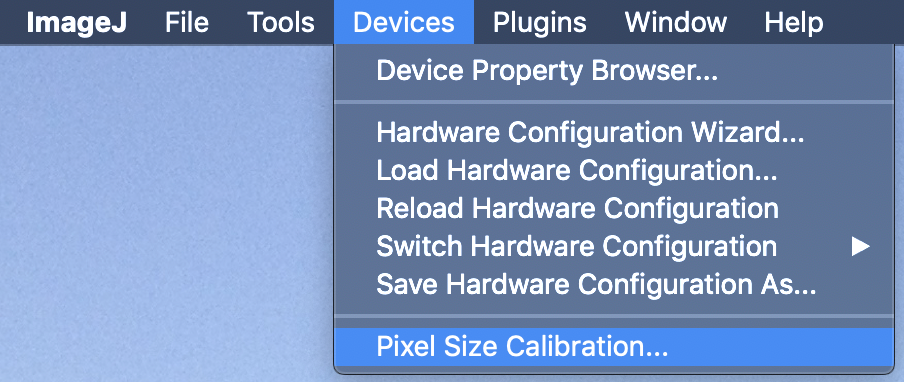

Then select "edit". Then use "calculate" or "measure" to either manually or automatically figure this out (You need a high contrast sample that is firmly secured in place to get an accurate calibration)

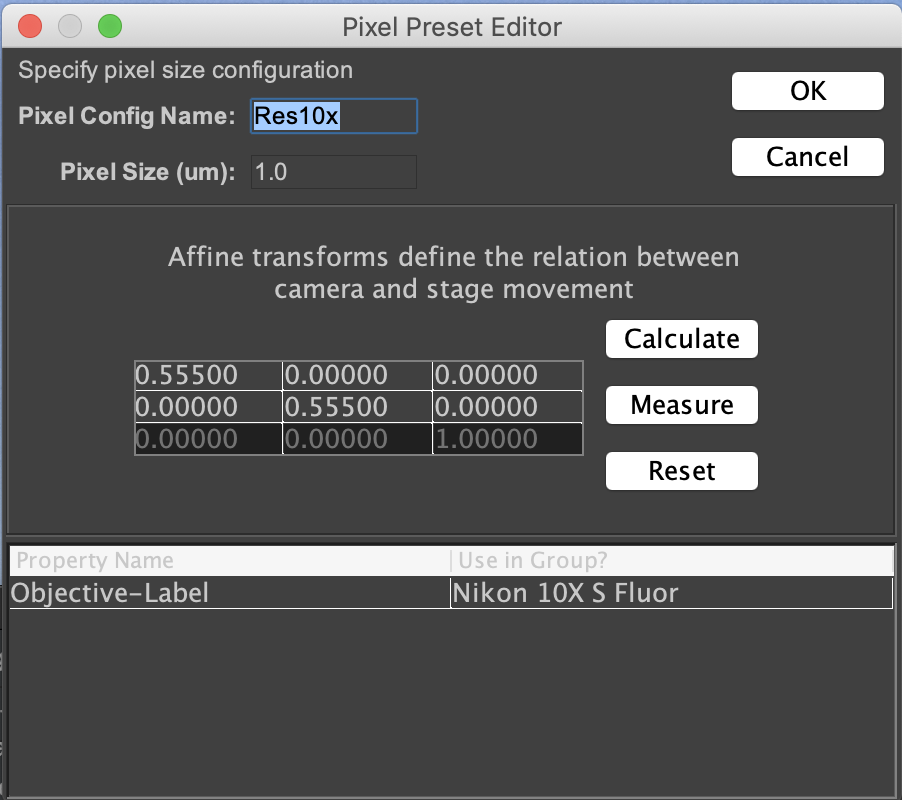

Now that everything is calibrated, we can use Micro-Magellan's "Explore" mode to collect training data. [This video](https://www.youtube.com/watch?v=cstzfkzDxA4&feature=youtu.be) shows how to navigate around a sample in X,Y, and Z, finding positions correctly in focus, and setting up a 3 point calibration to mark the tilt of the sample (**Note: this is from an earlier version of Magellan, and GUI controls have now moved around, in particular the Z explore control moved from under the image to in the Explore pane on the top right**). 

After following a similar procedure, we can set up collection of many Z stacks using acquisition settings something like this:

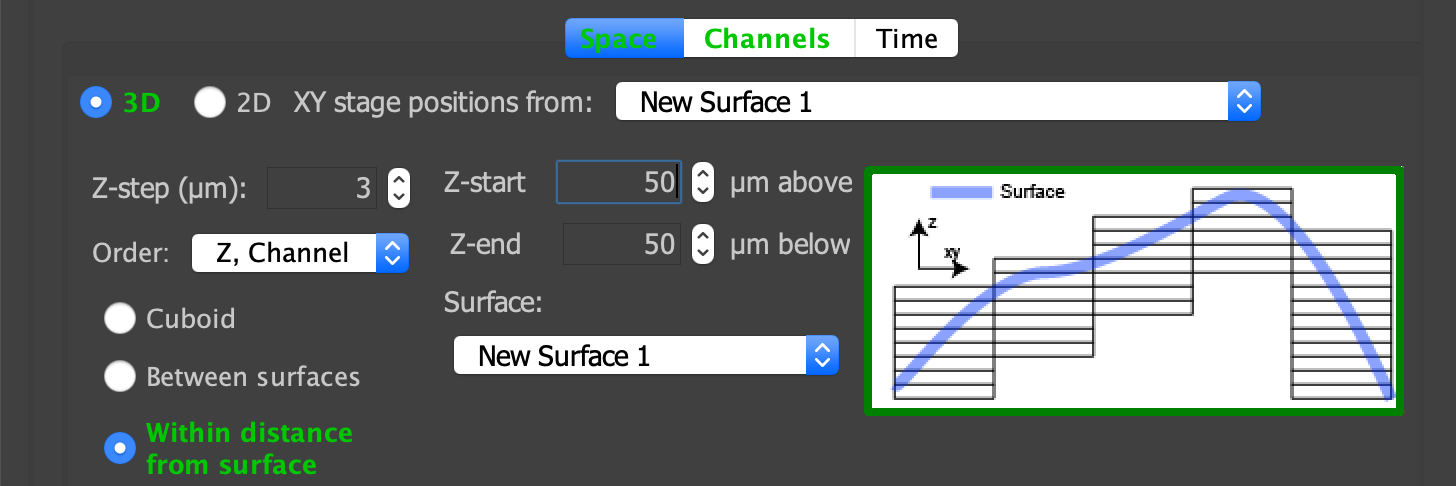

We also want to use two different channels, corresponding to the two different illuminations described previously

### Opening the data

Using the pycro-manager `Dataset` class, we can easily read the data we just collected


In [3]:
from pycromanager import Dataset

##TODO: your dataset path here
dataset_dir = '/Users/henrypinkard/tmp/experiment_1_65'

# open the dataset
dataset = Dataset(dataset_dir)
# open the data as one big array (with an axis corresponding to xy position)
data = dataset.as_array()
# print the names of the axes 
print(dataset.axes.keys())
# show general information about the data
data

Dataset opened of 10
dict_keys(['z', 'position', 'channel'])


dask.array<stack, shape=(34, 12, 2, 512, 512), dtype=uint16, chunksize=(1, 12, 2, 512, 512), chunktype=numpy.ndarray>

From the above, we can see that we have a 34 z-slice, 12 xy position, 2 channel dataset with images that are 512x512. We can now use this data to perform the training described in the other notebook.

One thing you might wonder is how much data needs to be collected? This is likely very sample dependent, but this figure below from the paper should give some idea of of performance vs training data size

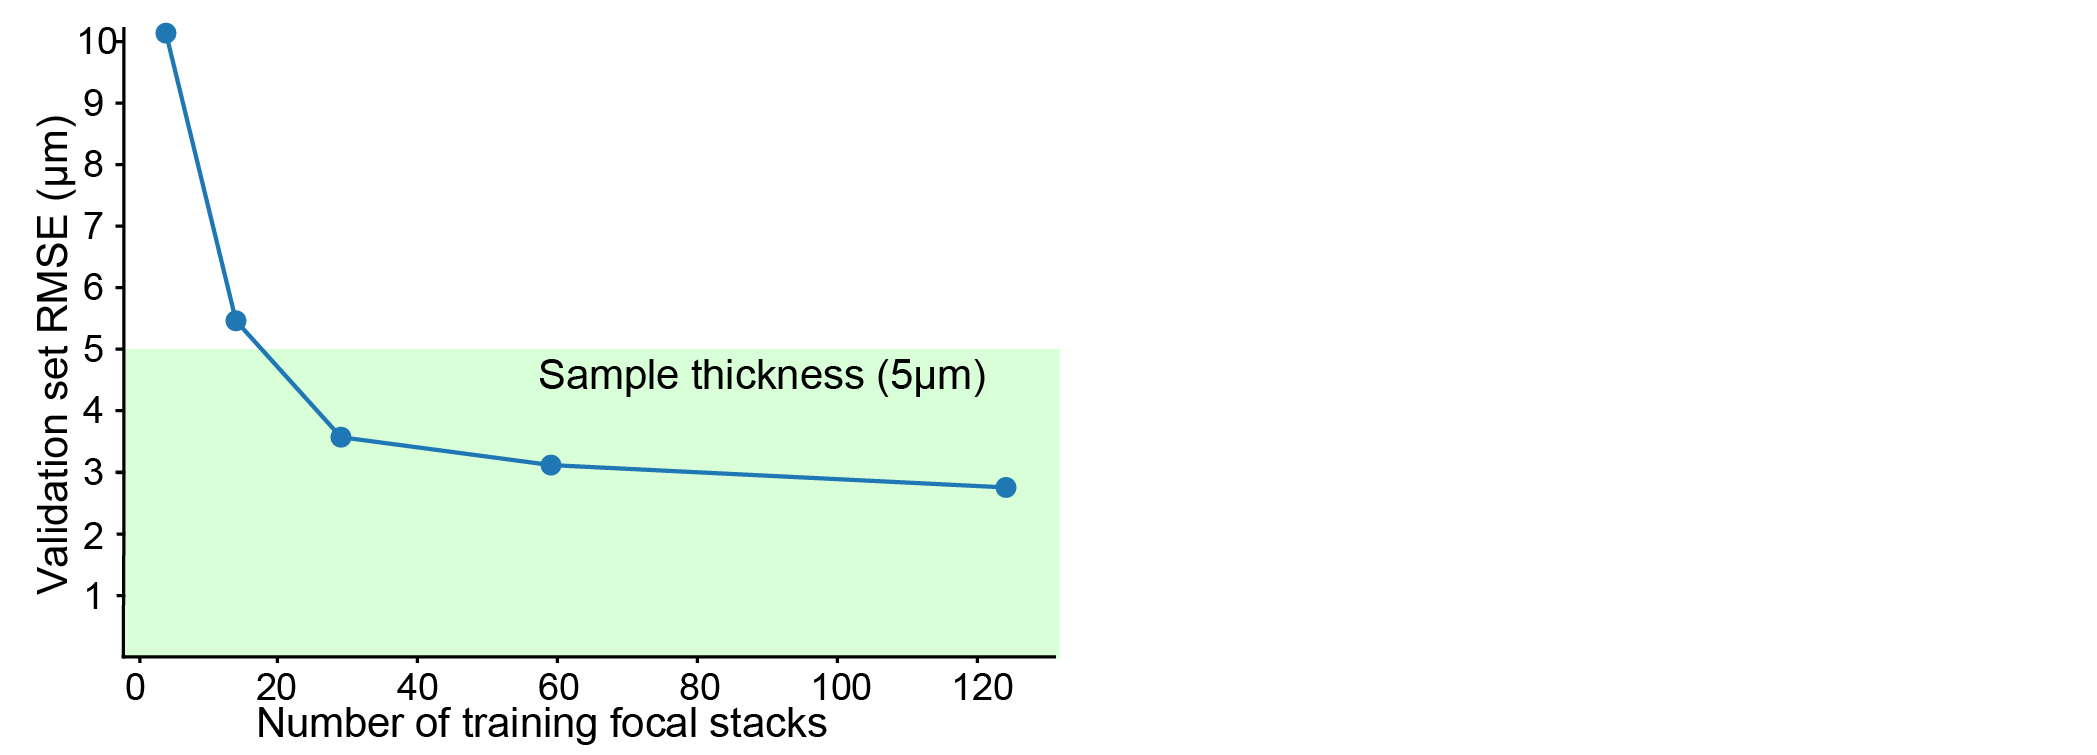

## 3) Use trained network to apply focus corrections during experiments 

For this part of the tutorial, we assume that a focus prediction model has been trained (potentially using code in the other notebook), and assume that we have some object `model` to which we can pass an image and have it give us a prediction for how far out of focus that image is (i.e. `focus_offset = model.predict(numpy_image)`) 

We can apply these focus corrections using Pycro-Manager [acquisition hooks](https://pycro-manager.readthedocs.io/en/latest/acq_hooks.html). These can be applied to multiple different types of acquisitions. For simplicity here, we show how to do this with [multi-dimensional acquisitions](https://pycro-manager.readthedocs.io/en/latest/acq_events.html#multi-dimensional-acquisitions) in Pycro-Manager, but the same hook code can be applied to Micro-Magellan acquisitions as well.

In [ ]:
from pycromanager import Acquisition, multi_d_acquisition_events, Core

### TODO:
# model = some_trained_model

save_name = 'autofocus_test'
save_dir = '/Users/henrypinkard/tmp/'


# This hook function will do the autofocusing
def hook_fn(event, event_queue):

    if not hasattr(hook_fn, 'time_index'):
        hook_fn.time_index = event['axes']['time']

    # Only apply this focus correction at the beginning of a new time point (except the first one)
    if event['axes']['time'] != hook_fn.time_index:
        # get the Micro-Manager core
        core = Core()
    
        core.snap_image()
        tagged_image = core.get_tagged_image()
        # pixels by default come out as a 1D array. We can reshape them into an image
        pixels = np.reshape(tagged_image.pix,
                            newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])
        # use the image to predict focus correction
        focus_correction = model.predict(pixels)
        # Apply the predicted correction
        z_device_name = core.get_focus_device()
        core.set_position(z_device_name, core.get_position(z_device_name) + focus_correction)

    # Keep track of last time point on which autofocus ran 
    hook_fn.time_index = event['axes']['time']

    return event


# This acquisition runs with the Micro-Manager demo config
with Acquisition(directory=save_dir, name=save_name, post_hardware_hook_fn=hook_fn) as acq:
    events = multi_d_acquisition_events(
        num_time_points=4, time_interval_s=0,
        channel_group='Channel', channels=['DAPI', 'FITC'],
        z_start=0, z_end=6, z_step=0.4,
        order='tcz')
    acq.acquire(events)
